In [1]:
import torch
import torchvision.models as models
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
import os

data_dir = 'data/hymenoptera_data'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=5,
        shuffle=True, num_workers=4
    )
    for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda:0


# Training 

In [4]:
from utils import train_model

In [5]:
model_resnet = torchvision.models.resnet18(pretrained=True)

# Freeze the network
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
print("Original # features: ", num_ftrs)

model_resnet.fc = nn.Linear(num_ftrs, 256)
model_resnet = model_resnet.to(device)
criterion = nn.MSELoss()
optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Original # features:  512


In [6]:
from torchsummary import summary

# summary(model_resnet, (3, 224, 224))
# del model_resnet.fc
# del model_resnet.avgpool

# print("Last Dim: ", model_resnet.layer2[-1].conv2)

print("Last Dim: ", model_resnet.fc)

Last Dim:  Linear(in_features=512, out_features=256, bias=True)


# Calculate Conv Output 
$$
[(W−K+2P)/S]+1
$$
or
$$
W - (K-1)
$$

- $W$: input volume
- $K$: kernel size
- $p$: padding
- $s$: stride

In [7]:
input_size = 32
kernel_size = 5
strides = 1
padding = 0

# deconv
output_size = strides * (input_size-1) + kernel_size - 2*padding
output_size

36

In [8]:
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, z_dim, model_resnet):
        super(Decoder, self).__init__()

        self.encoder = model_resnet

        self.decFC1 = nn.Linear(z_dim, 32 * 216 * 216)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, 3, 5)

    def forward(self, x):

        x = self.encoder(x)

        x = F.relu(self.decFC1(x))
        x = x.view(-1, 32, 216, 216)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))

        return x


In [9]:
model_decoder = Decoder(256, model_resnet)
model_decoder = model_decoder.to(device)

In [10]:
model_decoder = train_model(
    model_decoder, criterion, optimizer_conv,
    exp_lr_scheduler, device, dataloaders,
    dataset_sizes, num_epochs = 10
)

Epoch 0/9
----------
train Loss: 1.7709
val Loss: 1.6857

Epoch 1/9
----------
train Loss: 1.7842
val Loss: 1.6844

Epoch 2/9
----------
train Loss: 1.7806
val Loss: 1.6838

Epoch 3/9
----------
train Loss: 1.7835
val Loss: 1.6826

Epoch 4/9
----------
train Loss: 1.7949
val Loss: 1.6820

Epoch 5/9
----------
train Loss: 1.7810
val Loss: 1.6816

Epoch 6/9
----------
train Loss: 1.7696
val Loss: 1.6805

Epoch 7/9
----------
train Loss: 1.8010
val Loss: 1.6803

Epoch 8/9
----------
train Loss: 1.7586
val Loss: 1.6807

Epoch 9/9
----------
train Loss: 1.7961
val Loss: 1.6805

Training complete in 1m 35s
Best val Acc: 0.000000


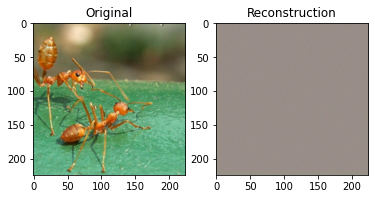

In [72]:
import matplotlib.pyplot as plt
import random

model_decoder.eval()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

with torch.no_grad():
    _data = next(iter(dataloaders['val']))
    # for img in _data[0]:
    img = _data[0][0]
    plt.figure()
    # Original
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    plt.subplot(121)
    plt.title("Original")
    plt.imshow((img * 255).astype(np.uint8))


    # Reconstruction
    img = _data[0]
    img = img.to(device)
    outimg = model_decoder(img)
    # get 1 image
    outimg = outimg[0]
    outimg = outimg.cpu().numpy().transpose((1, 2, 0))
    outimg = std * outimg + mean
    plt.subplot(122)
    plt.imshow((outimg * 255).astype(np.uint8))
    plt.title("Reconstruction")
    plt.show()